# QUESTION 1

# Importing Data

Before all else, the data must be properly import, in this case, through the use of `pandas.read_csv()`.

In [1]:
import pandas as pd

# define a function for code reproducability later one (more seasons, inclusion of more pitch types, etc.)
def read_data(path):
    '''
    Reads in csv files for a given absolute or relative path.
    '''
    try:
        df = pd.read_csv(path)
        return df
    except FileNotFoundError as e:
        print(f'{e}\nRerun with an existing filename.')

In [2]:
train = read_data('Q1_pitches_train.csv')
test = read_data('Q1_pitches_test.csv')

And view the first few rows of the dataframes to ensure error-free imports: 

In [3]:
train.head()

,inning,is_bottom,balls,strikes,outs_before,is_lhp,is_lhb,pitch_type,bat_score_before,field_score,basecode_before,batterid,pitcherid,cid
0,3,0,1,0,1,0,1,FF,0,1,0,347,1304,2014
1,1,0,2,2,2,1,0,FF,0,0,0,269,1661,2052
2,2,1,0,0,0,0,0,FT,0,0,0,43,1048,2029
3,7,0,0,0,1,0,0,FF,5,1,1,98,1521,2049
4,7,1,0,0,2,1,1,SL,6,1,1,460,1100,2050


In [4]:
test.head()

,inning,is_bottom,balls,strikes,outs_before,is_lhp,is_lhb,bat_score_before,field_score,basecode_before,batterid,pitcherid,cid,FF,FT,CB,SL,CH
0,9,1,0,0,0,0,1,2,4,0,1,1000,2000,NaN,NaN,NaN,NaN,NaN
1,9,0,0,0,2,0,0,4,2,0,2,1001,2001,NaN,NaN,NaN,NaN,NaN
2,9,0,1,1,1,0,0,4,2,0,3,1001,2001,NaN,NaN,NaN,NaN,NaN
3,9,0,0,2,0,0,0,4,2,0,4,1001,2001,NaN,NaN,NaN,NaN,NaN
4,9,0,1,2,0,0,0,4,2,0,4,1001,2001,NaN,NaN,NaN,NaN,NaN


Looks good! Some potential issues that could arise with this method include an unconventional delimiter (tab | ;) or an incorrect index column.

# Exploratory Analysis -  Value Interpretation

There are some columns that are easy to understand by just observation like `inning`, `balls`, `strikes`, or `outs_before`. Yet some remain obscure like `basecode_before` or `cid`. Further analysis is needed, namely viewing using `df.info()` to view the data-types, as well as other key attributes.

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 480915 entries, 0 to 480914
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   inning            480915 non-null  int64 
 1   is_bottom         480915 non-null  int64 
 2   balls             480915 non-null  int64 
 3   strikes           480915 non-null  int64 
 4   outs_before       480915 non-null  int64 
 5   is_lhp            480915 non-null  int64 
 6   is_lhb            480915 non-null  int64 
 7   pitch_type        480915 non-null  object
 8   bat_score_before  480915 non-null  int64 
 9   field_score       480915 non-null  int64 
 10  basecode_before   480915 non-null  int64 
 11  batterid          480915 non-null  int64 
 12  pitcherid         480915 non-null  int64 
 13  cid               480915 non-null  int64 
dtypes: int64(13), object(1)
memory usage: 51.4+ MB


There are 480,915 rows (pitches) with 13 columns, all of type int64 (numeric w/ 64 bit capacity) except `pitch_type` which is of type object (string). 

In [6]:
train.select_dtypes(include = "object").head() # strings

,pitch_type
0,FF
1,FF
2,FT
3,FF
4,SL


The column `pitch_type` is the only non-numerical data-type and happens to be the label for this classification problem (i.e. aiming to predict pitch type).

In [7]:
train.select_dtypes(include = 'int64').head() # numerical data

,inning,is_bottom,balls,strikes,outs_before,is_lhp,is_lhb,bat_score_before,field_score,basecode_before,batterid,pitcherid,cid
0,3,0,1,0,1,0,1,0,1,0,347,1304,2014
1,1,0,2,2,2,1,0,0,0,0,269,1661,2052
2,2,1,0,0,0,0,0,0,0,0,43,1048,2029
3,7,0,0,0,1,0,0,5,1,1,98,1521,2049
4,7,1,0,0,2,1,1,6,1,1,460,1100,2050


All of these numerical columns include information about the gamestate of the given pitch. In this way, though these are numerical figures, they have categorical meanings that are encoded. It is key to understand that by nature, this is a fundamentally different modeling problem than identifying a pitch given a certain spinrate or movement pattern. Instead, this model should predict the highest likelihoods for facing a pitch given the in game situation, with no relevant information about the pitch itself.

### Feature Domains

It is imperative to understand all the possible values that columns can take on:

In [8]:
print(train.nunique())

inning               19
is_bottom             2
balls                 4
strikes               3
outs_before           3
is_lhp                2
is_lhb                2
pitch_type            5
bat_score_before     23
field_score          23
basecode_before       8
batterid            988
pitcherid           830
cid                 113
dtype: int64


Immediately, there are assumptions that can be made about the domains of a few of the aforementioned more straightforward variables:

   - **inning**: the inning of the pitch - [1,20]
   - **is_bottom**: bottom/top half inning - binary {0,1}
   - **balls**, **strikes**, **outs_before**: gamestate before pitch - [0,3], [0,2], [0,2]
   - **is_lhp**, **is_lhb**: handedness of pitcher and batter - both binary {0,1},{0,1}
   - **bat_score_before**, **field_score**: score of teams before pitch - [0,22], [0,22]
   - **pitch_type** (label): type of pitch thrown - {**'FF' = 4-seamer**,**'SL' = slider** ,**'FT' = 2-seamer**,**'CH' = changeup**,**'CB' = curveball**}
   - **batterid**, **pitcherid**, **cid**: keys for identification


And visualization of their distributions...

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# define a function for code reuse
def visualize_col_domains(col, df,c):
    """
    Visualizes categorical columns of a dataframe
    Parameters:
    col (str): the column name of the passed in dataframe
    df (DataFrame): the DataFrame to visualize cols
    """
    color = 'blue' 
    if c%2 == 0: 
        color = 'orange'
    plt.bar(df[col].value_counts().keys(), df[col].value_counts().values, color =color) # mets colors
    plt.xticks(ticks = np.arange(0,len(df[col].value_counts())), labels = df[col].value_counts().keys(),rotation = 45) # set ticks to be range, with labels of the index of value counts
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.title(f'Counts of Categorical Column: {col}')
    

For the sake of practicality, it is important to limit the graphs to columns with a reasonable amount of possible values (excluding the id's). 

In [10]:
reasonable_domains = []
for col in train.columns:
    if(len(train[col].value_counts()) <= 23): # excluding ids, including all other columns
        reasonable_domains.append(col)

In [11]:
reasonable_domains

['inning',
 'is_bottom',
 'balls',
 'strikes',
 'outs_before',
 'is_lhp',
 'is_lhb',
 'pitch_type',
 'bat_score_before',
 'field_score',
 'basecode_before']

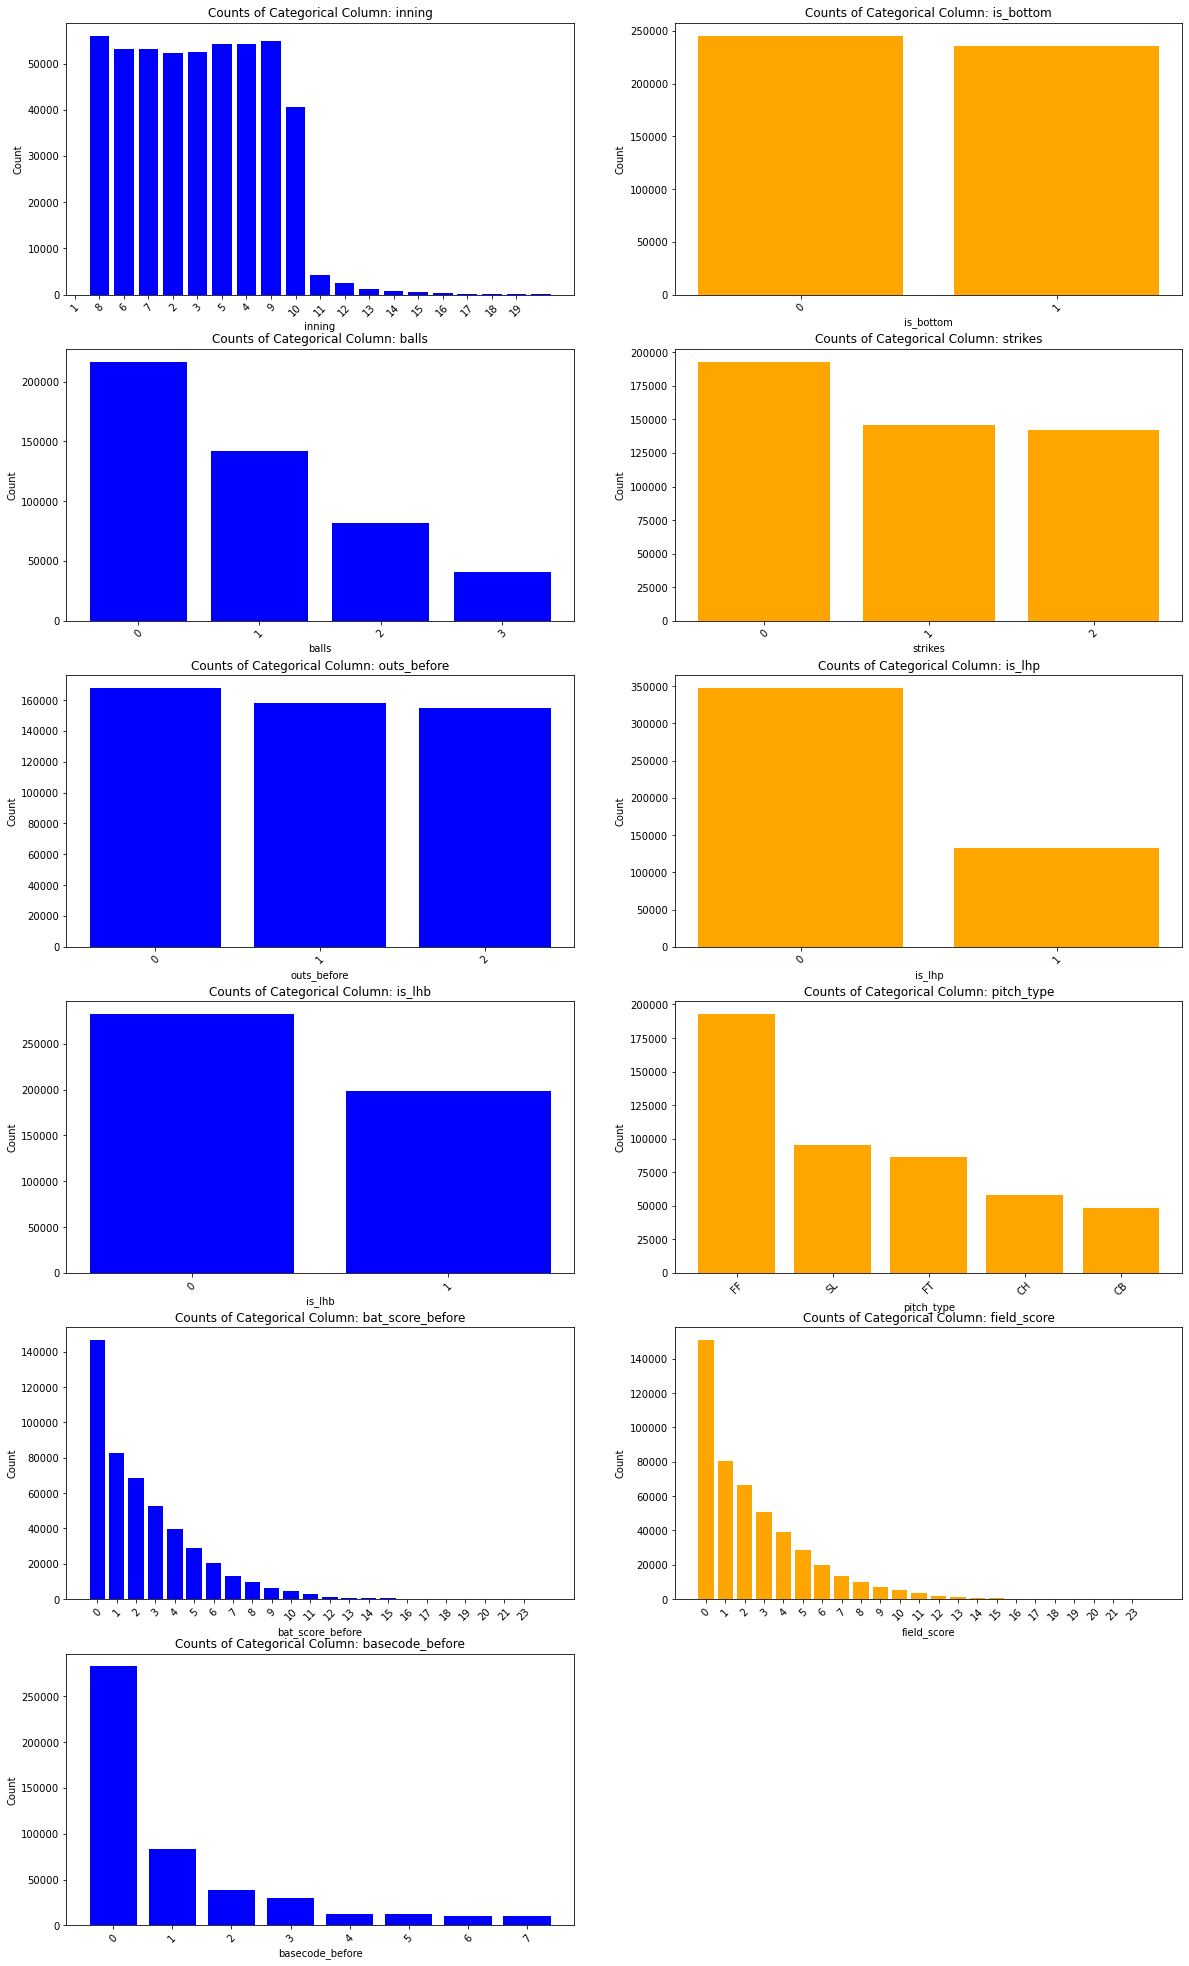

In [12]:
plt.figure(figsize =(20,35))
for i in range(1,len(reasonable_domains)+1):
    plt.subplot(6,2,i)
    visualize_col_domains(reasonable_domains[i-1],train,i)
plt.show()


This data mirrors their likely rate of occurences in MLB games: innings remain constant for innings 1 through 9 then decrease for each extra inning, most pitchers and hitters are righties, and more 0 strike 0 ball and 0-0 score pitches.

The most influential visualization is of the labels - pitch type. Again following this real-world based hypothesis, one would expect the most 4-seam fastballs. This is the case, and it signifies that any model will 'learn' the gamestates that signify a fastball the closest. Subsequent accuracy analysis should display this. FOr that reason, only an equal sample of each pitch type will be used for training, with around 50,000 samples of each (least common pitch - CB samples). This will be done later before model selection.

So, there remains a column that are harder to understand: `basecode_before`.

Upon reflection, this basecode figure is encoded  representing the positioning of runners on base at the time the pitch is thrown. It can be inferred it can be decoded as follows: 
- 0: bases empty
- 1: (man on) 1st
- 2: 2nd
- 3: 3rd
- 4: 1st and 2nd
- 5: 1st and 3rd
- 6: 2nd and 3rd
- 7: bases loaded

This conclusion fits the narrative of the visualization above. The most pitches take place with the bases empty, with far less coming with any configuration of baserunners.

Although the training set data is fully investigated, this must be compared with the test set, which could have extraneous columns.

In [13]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160306 entries, 0 to 160305
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   inning            160306 non-null  int64  
 1   is_bottom         160306 non-null  int64  
 2   balls             160306 non-null  int64  
 3   strikes           160306 non-null  int64  
 4   outs_before       160306 non-null  int64  
 5   is_lhp            160306 non-null  int64  
 6   is_lhb            160306 non-null  int64  
 7   bat_score_before  160306 non-null  int64  
 8   field_score       160306 non-null  int64  
 9   basecode_before   160306 non-null  int64  
 10  batterid          160306 non-null  int64  
 11  pitcherid         160306 non-null  int64  
 12  cid               160306 non-null  int64  
 13  FF                0 non-null       float64
 14  FT                0 non-null       float64
 15  CB                0 non-null       float64
 16  SL                0 

There are 160,306 test pitches, significantly less than the training pitches. 

There are some columns present in the testing set, that are not in the training set (and vice-versa).

In [14]:
for col in train.columns:
    if col not in test.columns:
        print(f"Column '{col}' in train data but not test data.")

for col in test.columns:
    if col not in train.columns:
        print(f"Column '{col}' in test data but not train data.")

Column 'pitch_type' in train data but not test data.
Column 'FF' in test data but not train data.
Column 'FT' in test data but not train data.
Column 'CB' in test data but not train data.
Column 'SL' in test data but not train data.
Column 'CH' in test data but not train data.


The first of these discrepencies is trivial: the label SHOULD be absent from the test data. The only other differences are the names of pitch types, which become more comprehensible when viewed below.

In [15]:
test[['FF','FT','CB','SL','CH']]

,FF,FT,CB,SL,CH
0,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
160301,NaN,NaN,NaN,NaN,NaN
160302,NaN,NaN,NaN,NaN,NaN
160303,NaN,NaN,NaN,NaN,NaN
160304,NaN,NaN,NaN,NaN,NaN


These columns prove to be placeholders for the required format of the output. The predictions 
should mirror the pattern typical of a dummy variable instead of in a single column. A dummy variable is typically used to explode a categorical variable by having separate columns for each possible output, with 0's for the absense and 1 for the presence. 

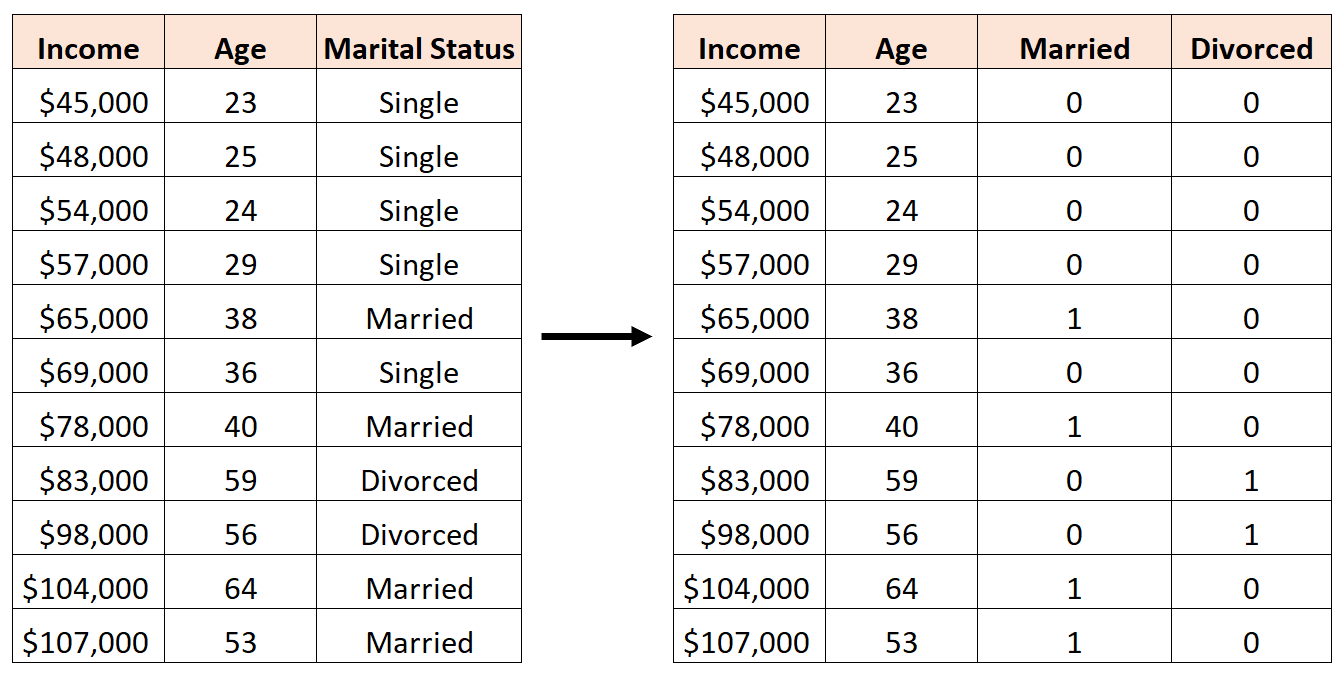

This output requirement should be noted and model predictions should fill these columns.

### Duplicate Check

It is imperative to discern potential duplicated entries when working with an unknown data source.

In [16]:
def check_dupes(df):
    if (df.duplicated().sum() == 0): # duplicated () checks each row for dupe, if sum of booleans == 0 -> all false
        print("No row is a duplicate entry.")
    else:
        print("There is at least one duplicate entry.")

In [17]:
check_dupes(train)
check_dupes(test)

There is at least one duplicate entry.
There is at least one duplicate entry.


There proves to be duplicate pitches present in the dataset for both training and testing pitches. This makes sense, however, due to the categorical nature of all features. Two duplicate entries can simply occur in the following scenerio: the same 2 strike pitch after a foul within the same at bat.

In [18]:
dupes = train[train.duplicated(keep=False)]
dupes

,inning,is_bottom,balls,strikes,outs_before,is_lhp,is_lhb,pitch_type,bat_score_before,field_score,basecode_before,batterid,pitcherid,cid
1,1,0,2,2,2,1,0,FF,0,0,0,269,1661,2052
62,8,1,1,2,1,0,0,SL,1,0,0,220,1254,2071
69,9,0,3,2,2,1,0,FF,6,2,4,127,1441,2025
146,5,0,2,2,0,1,0,FF,0,4,0,88,1499,2043
153,6,0,2,2,1,1,0,FF,4,0,0,446,1287,2009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
480779,9,1,1,2,0,0,0,SL,0,3,1,596,1451,2003
480825,7,1,3,2,1,1,0,SL,2,6,0,244,1288,2071
480836,7,0,3,2,2,0,1,SL,1,2,0,45,1082,2008
480896,2,1,1,2,1,0,0,SL,0,0,6,171,1122,2003


This is only a modicum of total pitches in the training set (19,413 of over 480,000), however, it is nonetheless important to account for their presence.

For illustration, view the first duplicatated pitch (which happens to be of index 1).

In [19]:
dupes.loc[((train['pitcherid'] == dupes.loc[1,'pitcherid']) \
           & (train['batterid'] == dupes.loc[1,'batterid']))]

,inning,is_bottom,balls,strikes,outs_before,is_lhp,is_lhb,pitch_type,bat_score_before,field_score,basecode_before,batterid,pitcherid,cid
1,1,0,2,2,2,1,0,FF,0,0,0,269,1661,2052
84191,1,0,2,2,2,1,0,FF,0,0,0,269,1661,2052


It is very plausible that this duplicate is simply repeated fastballs on a 0-2 count when the first one is fouled off. To narrow the search for potential true duplicates, we can view the non-two strike instances.

These are bound to be rarer, as they are required to happen in separate games. Still, within divisional rivalries, pitchers can face an opposing batter multiple times a season with identical gamestates. The vast majority occurring with SP against 1, 2 or 3 hitters in the lineup (i.e. 0-0 top 1st/bottom 1st).

In [20]:
dupes.loc[dupes['strikes'] != 2]

,inning,is_bottom,balls,strikes,outs_before,is_lhp,is_lhb,pitch_type,bat_score_before,field_score,basecode_before,batterid,pitcherid,cid
309,1,0,1,0,1,1,0,FT,0,0,0,7,1012,2002
1541,1,0,0,0,0,0,1,FF,0,0,0,506,1416,2003
2162,1,0,0,1,0,0,1,FF,0,0,0,430,1500,2009
2238,9,0,0,1,2,0,0,CB,19,4,1,142,1756,2015
4395,2,1,0,0,1,0,1,FF,0,0,0,544,1654,2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
476607,1,0,0,0,0,0,0,FF,0,0,0,330,1256,2049
478670,4,1,0,1,0,1,1,CH,1,2,0,460,1059,2018
480247,1,1,0,0,1,0,1,CB,0,0,2,76,1048,2029
480599,1,1,0,0,0,0,1,FF,0,0,0,182,1279,2054


Now only a fraction (316 of 480,000)! 

Viewing the first indexed dupe...

In [21]:
dupes.loc[((train['pitcherid'] == dupes.loc[309,'pitcherid']) & (train['batterid'] == dupes.loc[309,'batterid']))]

,inning,is_bottom,balls,strikes,outs_before,is_lhp,is_lhb,pitch_type,bat_score_before,field_score,basecode_before,batterid,pitcherid,cid
309,1,0,1,0,1,1,0,FT,0,0,0,7,1012,2002
31169,1,0,0,0,1,1,0,FT,0,0,0,7,1012,2002
52944,1,0,1,0,1,1,0,FT,0,0,0,7,1012,2002
97483,1,0,0,0,1,1,0,FT,0,0,0,7,1012,2002


Once the gamestate advances past the first few innings, it becomes exponentially more unlikely that these persistent duplicates would be due to their actual occurrences, rather than an error in data entry or engineering. Now, these pitches can be sorted out. The logic to identify these will be to filter entries when either team had a run or more.

In [22]:
unlikely_dupes  = dupes.loc[((dupes['strikes'] != 2) &\
            (dupes['inning'] != 1) &\
             (dupes['bat_score_before'] >=1) & \
              (dupes['field_score']>=1))]
unlikely_dupes

,inning,is_bottom,balls,strikes,outs_before,is_lhp,is_lhb,pitch_type,bat_score_before,field_score,basecode_before,batterid,pitcherid,cid
2238,9,0,0,1,2,0,0,CB,19,4,1,142,1756,2015
101437,8,0,1,1,0,0,1,FF,5,7,0,1,1215,2000
150866,4,1,0,1,0,1,1,CH,1,2,0,460,1059,2018
225857,5,0,0,0,0,0,0,FF,1,1,0,132,1209,2017
227657,9,0,0,1,0,0,0,SL,1,2,0,188,1178,2007
256719,8,1,0,0,0,0,1,FF,10,1,0,293,1281,2100
320203,8,0,1,1,0,0,1,FF,5,7,0,1,1215,2000
332079,9,0,0,1,0,0,0,SL,1,2,0,188,1178,2007
343587,9,0,0,1,2,0,0,CB,19,4,1,142,1756,2015
355173,8,1,0,0,0,0,1,FF,10,1,0,293,1281,2100


It is these few duplicates that are bound to push the limit of what is possible in repeated gamestates, with particularly egregious 19-4 repeats. For this reason, it is fair to assume these are true duplicates that need to be handled. Therefore, only the first instances of these will be counted.

In [23]:
unlikely_dupes.drop_duplicates(keep = 'last') # to drop
index_to_drop = unlikely_dupes.index # get indeces to drop

length_before = len(train) # original length
train.drop(index = index_to_drop,inplace=True, axis = 0) # proceed with drop
train.reset_index(inplace = True,drop = True) # reset index to avoid gaps 

assert (len(train) + len(index_to_drop) == length_before) # assertion

It is unnecessary to account for repeats in the test data, as this has no influence over the model. The only thing that would result from repeated test pitches, is the same prediction. 

### Null Check

Now, a final null check...

In [24]:
def check_nulls(df):
    if(train.isna().sum().sum() == 0):
        print("No row contains a null or NaN value.")
    else:
        print("There is a null or NaN value in this table.")

In [25]:
check_nulls(train) # passes
check_nulls(test) # passes

No row contains a null or NaN value.
No row contains a null or NaN value.


### Preventing Multicolinearity

The last step before model training is to check for multicolinearity. Colinearity can be seen as the propensity to which two independent, predictor variables have a linear relationship each other. When this occurs, it is impossible to measure what is affecting the dependent variable, and leads to an increased p-value for each coefficient. This signifies decreased statistical significance of the findings.

There are many ways to allieviate this, but perhaps the most simple, is to drop one of a colinear pair of variables. This should be done carefully and key features should be preserved. To judge for colinearity, a view of the correlation pairs of each feature are displayed below.



Given the amount of features, the lack of extreme colinearity bodes well for modelling. The highest correlation between features is inning's correlation with the team scores. This is quite obvious, as more runs will be scored as the inning number increases.



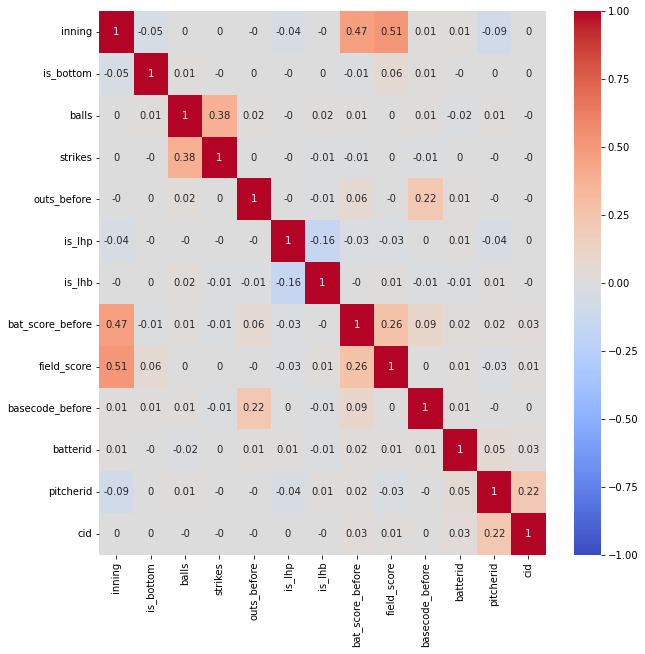

In [26]:
import seaborn as sns

corr = train.corr()
plt.figure(figsize = (10,10))
sns.heatmap(corr.round(2), vmax = 1, vmin = -1, center = 0, annot =True, cmap = 'coolwarm')
plt.show()

Given the amount of features, the lack of colinearity bodes well for modelling. The highest correlation between features is inning's correlation with the team scores. This is quite obvious, as more runs will be scored as the inning number increases. Still, this is not an extremely significant correlation and, thus, no action should be taken.

# Modeling

### Feature Selection

Before any models are selected and trained, it is necessary to distinguish useful columns to be features in the models from others.

Let's take another look at the training set.

In [27]:
train.head()

,inning,is_bottom,balls,strikes,outs_before,is_lhp,is_lhb,pitch_type,bat_score_before,field_score,basecode_before,batterid,pitcherid,cid
0,3,0,1,0,1,0,1,FF,0,1,0,347,1304,2014
1,1,0,2,2,2,1,0,FF,0,0,0,269,1661,2052
2,2,1,0,0,0,0,0,FT,0,0,0,43,1048,2029
3,7,0,0,0,1,0,0,FF,5,1,1,98,1521,2049
4,7,1,0,0,2,1,1,SL,6,1,1,460,1100,2050


The ID's are simply keys that are used for player identification, and are irrelevant for modelling purposes. Still, they shouldn't be dropped as they can be used post modelling. For that reason, the original `train` dataframe is preserved.

Then, only around ~50,000 samples of each pitch type will progress to the next stage, as to prevent model bias.

In [28]:
X_train = train.copy()

# get least populated pitch size, and take random sample of that amount of pitches of each type 
sample_size = X_train['pitch_type'].value_counts().values[-1]
X_train = X_train.groupby('pitch_type').apply(lambda x: x.sample(sample_size)).reset_index(drop = True)

In [29]:
X_train['pitch_type'].value_counts()

CB    48086
CH    48086
FF    48086
FT    48086
SL    48086
Name: pitch_type, dtype: int64

In [30]:
assert np.all(X_train['pitch_type'].value_counts().values\
              == X_train['pitch_type'].value_counts().values[0]) # assert all sample sizes are the same now

The name of this new dataframe needs to be explained. Given a feature vector X (for each feature x, $X = x_1, x_2,...x_n$) and the label vector, $y$. Subsequently, the X and y dataframes would be split using a `train-test-split`. This procedure will be done later on, but not for this purpose, as the .csv files already separated the train and test sets. For that reason, the new dataframe is essentially the post-split `X_train`.

In [31]:
X_train.drop(['batterid','pitcherid','cid'],axis = 1, inplace = True) # proceed with drop

Now, the only other column that doesn't belong in the feature space is the label, 'pitch_type'. This is the `y_train` and will be defined as such, then removed from `X_train`.

In [32]:
y_train = X_train['pitch_type']
X_train.drop(['pitch_type'],axis = 1, inplace = True)

A similar procedure will be done for the test set with additional dropping of the null pitch type dummies.

In [33]:
X_test = test.copy() # copy test
X_test.drop(['batterid','pitcherid','cid'],axis = 1, inplace = True) # proceed with drop
X_test.drop(['FF','FT','CB','SL','CH'],axis = 1, inplace = True) # proceed with drop

For some of the models below, the string pitch types will not be valid labels. Instead, labels of type `int` are required. To remedy this, the pitches will simply be encoded according to the following map: 

In [34]:
temp = y_train.map({"FF":0,"FT":1, "SL":2, "CH":3, "CB":4}) # encode
 
y_train = temp.copy()
y_train

0         4
1         4
2         4
3         4
4         4
         ..
240425    2
240426    2
240427    2
240428    2
240429    2
Name: pitch_type, Length: 240430, dtype: int64

### Procedure/Model Selection

In [35]:
# before beginning, filter warnings that appear occasionally due to worker/processor timeout
import warnings
warnings.filterwarnings('ignore')

Since this data is already split into training and testing sets, there is no need to split it again for that purpose. However, there is a benefit to doing this for another reason: the validation set. 

The validation set provides an evaluation of the models fit to the data, and allows for hyperparameter tuning before finalization. This is fundamentally analagous to the test set, but is a subset of the training set. It is of the utmost importance to prevent the model from 'seeing' the test set, until final model scoring. In this case, using a validation set for tuning has added benefits; the validation set is labelled as it is a subset of the training set. Therefore, an accuracy score can be determined. This cannot be done for the unlabelled test set.

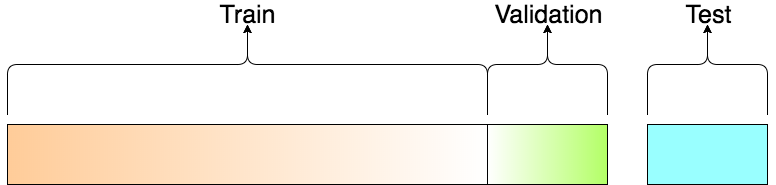

This will be done implicitly for each model by the `GridSearchCV` objects initialized below. Whenever a `GridSearch` is run for each model, an accuracy score is determined for each cartesian pair of multiple hyperparameters to determine the highest performing options. These hyperparameter options are selected in the `params` dictionaries. This is done with 5-fold cross validation (CV), or iteratively selecting different random selection of training samples to act as a validation set, a procedure that avoids overfitting.

A kNN model will also be fitted on the data. kNN or k-Nearest Neighbors is a non-linear model "for estimating the likelihood that a data point will become a member of one group or another based on what group the data points nearest to it belong to." [source](https://learn.g2.com/k-nearest-neighbor)

This includes two types of models: kNN classifier or kNN regressor. The former categorizes a 'best guess' based on the a consensus of the k nearest points, while the latter predicts a continuous variable. For example, a kNN classifier might predict a pitch of being type 10, while a regressor might predict a score of 9.42 for the same pitch.

In this case, a classifier is clearly the better choice due to the categorical label of `pitch_type`. 


One important preliminary step of kNN models is to scale the data. Because these models depend on Euclidean distance, scaling the data prevents that which has much larger scale from overinfluencing the model predictions. In this case, a standard scalar is used.

StandardScalar removes variance and reverts data to its z-score $$z = \frac{x-\mu}{\sigma}$$

In [36]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train) # fit and transform on training data

Also for kNN, principle component analysis (PCA) will be used. This method of dimensionality reduction is used "by projecting each data point onto only the first few principal components to obtain lower-dimensional data while preserving as much of the data's variation as possible". - [source](https://en.wikipedia.org/wiki/Principal_component_analysis)

This helps to mitigate some problems kNN has with high dimensional data, namely the 'Curse of Dimensionality', or inability to predict well in high dimensional spaces.

In [37]:
from sklearn.decomposition import PCA

my_PCA = PCA(n_components=8) # 8 components found to be happy medium preserving performance with significant reduction
my_PCA.fit(X_train_scaled) # fit on training 
X_train_PCA = my_PCA.transform(X_train_scaled)

Now all the data is scaled and ready for euclidean-distance based modelling. A kNN model is fitted below iteratively using different options for various hyperparameters:

- `k`: the amount of nearest neighbors to base classification guess off of
- `weights`: whether all k-points are weighted the same, or based of distance from point to guess

In [38]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
params = {'n_neighbors': np.arange(2,12,1),'weights': ['uniform', 'distance']}
gs = GridSearchCV(knn,param_grid=params,cv = 5,n_jobs = 3,verbose = 1)
gs.fit(X_train_PCA,y_train)

print(f'The best performing hyperparameters are {gs.best_params_} with accuracy score {gs.best_score_:.3f}.')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
The best performing hyperparameters are {'n_neighbors': 11, 'weights': 'uniform'} with accuracy score 0.248.


And viewing the accuracy scores with a visualizaton...

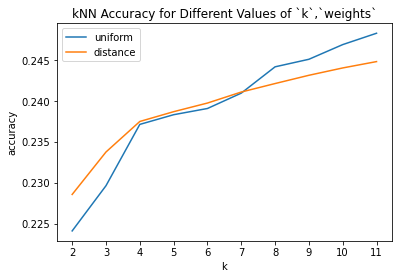

In [39]:
results = pd.DataFrame(gs.cv_results_)

plt.figure()
plt.plot(results.loc[results['param_weights'] == 'uniform','mean_test_score'],label = 'uniform')
plt.plot(range(0,20,2), results.loc[results['param_weights'] == 'distance','mean_test_score'].values,label = 'distance')
plt.xticks(ticks = range(0,20,2), labels = results.loc[results['param_weights'] == 'uniform','param_n_neighbors'].values.astype(int))
plt.legend()
plt.xlabel('k')
plt.ylabel('accuracy')
plt.title('kNN Accuracy for Different Values of `k`,`weights`')
plt.show()

It's clear that 'uniform' weights outperforms 'distance'as the value of `k` increases. Also, `k` and accuracy score seem to have a direct relationship. To test this, higher values will be used for `k` with fixed uniform scaling.

In [40]:
knn = KNeighborsClassifier(weights='uniform')
params = {'n_neighbors': np.arange(13,300,10)} # higher k's with fixed uniform weights
gs = GridSearchCV(knn,param_grid=params,cv = 5,n_jobs = 3,verbose = 1)
gs.fit(X_train_PCA,y_train)

print(f'The best performing hyperparameters are {gs.best_params_} with accuracy score {gs.best_score_:.3f}.')

Fitting 5 folds for each of 29 candidates, totalling 145 fits
The best performing hyperparameters are {'n_neighbors': 283} with accuracy score 0.288.


It seems that the accuracy score peaks at around 29% for kNN, when using validation set to predict pitch occurrences. 

The next model to be trained is a Random Forest. This is an ensemble learning based model that aggregates majority votes of sample classification by polling multiple decision trees at once. This aggregation prevents a singular decision trees tendency to 'learn' training data to closely. The original `X_train` is used as scaling and PCA use is unnecessary. 

A RF model fitted below iteratively using CV for hyperparameters:

- `n_estimators`: the amount of decision trees to aggregate from
- `max_depth`: the max number of splits for each estimator

In [41]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()

dpth = [2**i for i in range(1,7)] # inc powers of two, with instance of no max depth (tree runs until each leaf is one sample)
dpth.append(None)

params = {
    "n_estimators":[2**i for i in range(0,10)],
    "max_depth":dpth
    
}
gs = GridSearchCV(rf,param_grid=params,cv = 5, n_jobs = 3,verbose = 1)
gs.fit(X_train,y_train)

print(f'The best performing hyperparameters are {gs.best_params_} with accuracy score {gs.best_score_:.3f}.')

Fitting 5 folds for each of 70 candidates, totalling 350 fits
The best performing hyperparameters are {'max_depth': 8, 'n_estimators': 256} with accuracy score 0.309.


This score mirrors the best performing kNN accuracy. 

The overall accuracy scores are less than desirable. However, this is somewhat expected due to the nature of what the features are in this dataset! Without information about the specific pitch characteristics, it is an extremely hard and inconsistent task to predict pitch types given a certain ingame situation. In fact, this relation is not a function, as one situation can map to multiple pitch types. In other words, a pitcher can throw pitch in his repertoire for any in game scenerio. Given these particulars about this classification problem, these lower accuracy scores are seen in a different light and being able to gain ~10% accuracy over random guessing (30% vs. 20% or 1/5) is signficant. In essense, this becomes a more computerized version of the cat and mouse game that pitchers and hitters have been playing for generations; there are certainly gamestates that signify a certain pitch will come, but will always be just an educated guess. Then, when pitchers become overly predictable, they can adjust strategy to surprise even the most well-studied of hitters, as in the case of increasingly popular 3-0 breaking ball.

The acquirement of specific pitch data would drastically improve performance. More continuous, numeric information about pitch characteristics such as speed, horizontal/vertical break, or spinrate would directly lead to distinguishing a pitch, without multiple possibilities as in this case. This method is a natural continuation as it would be a fundamental shift in this problem of pitch prediction, from probabilistic to deterministic.

In testing, this accuracy score could be increased (to about 40%) by using the original non-balanced training set samples, but this might be due to the output, which guessed 'FF' 99,99% of the time. In this way, it was bound to have higher scores due to the myriad of fastballs in the game (and likely the testing set). Though this value is lower, it provides a real prediction - not a response bias.

Nevertheless, pitch predictions will proceed with the best performing model with a minimal hyperparameter size - Random Forest. This maximizes the speed of the prediction process.

In [42]:
# redeclare model with best hyperparams
rf = RandomForestClassifier(max_depth=8,n_estimators = 256)

# fit on data
rf.fit(X_train,y_train)

# predict testing data
y_test = rf.predict(X_test)

# reverse the encoding from earlier 
temp = pd.Series(y_test).map({0:'FF',1:'FT', 2:"SL", 3:"CH", 4:"CB"}) # decode
 
# copy series that contains pitch predictions
y_test = temp.copy()
y_test.head()

0    FF
1    SL
2    SL
3    SL
4    SL
dtype: object

In [43]:
# more balanced prediction space
y_test.value_counts()

CH    52673
SL    51469
CB    22717
FT    21224
FF    12223
dtype: int64

Interestingly, changeup and slider are the most guessed pitches.

In [44]:
# reorder to match original .csv file
pred = pd.get_dummies(y_test).iloc[:,[2,3,0,4,1]] 
pred.head()

,FF,FT,CB,SL,CH
0,1,0,0,0,0
1,0,0,0,1,0
2,0,0,0,1,0
3,0,0,0,1,0
4,0,0,0,1,0


In [45]:
# plug back into the placeholders
for col in pred:
    test[col] = pred[col]
test.head()

,inning,is_bottom,balls,strikes,outs_before,is_lhp,is_lhb,bat_score_before,field_score,basecode_before,batterid,pitcherid,cid,FF,FT,CB,SL,CH
0,9,1,0,0,0,0,1,2,4,0,1,1000,2000,1,0,0,0,0
1,9,0,0,0,2,0,0,4,2,0,2,1001,2001,0,0,0,1,0
2,9,0,1,1,1,0,0,4,2,0,3,1001,2001,0,0,0,1,0
3,9,0,0,2,0,0,0,4,2,0,4,1001,2001,0,0,0,1,0
4,9,0,1,2,0,0,0,4,2,0,4,1001,2001,0,0,0,1,0


In [46]:
test.to_csv('Q1_pitch_predictions.csv')